# This notebook shows how to fit a resonator with Kerr nonlinearity in the reflection configuration.

In [1]:
%matplotlib inline
from __future__ import division, absolute_import, print_function

import matplotlib.pyplot as plt
import numpy as np

from resonator import background, reflection, see

Create data using the model plus gaussian noise. The model is the product of the nonlinear reflection resonator model and a background model, which in this case assumes that the magnitude and phase are independent of frequency.

When the input photon rate exceeds a critical value, the photon number in the resonator has two stable states (and one unstable state that cannot be observed) that correpond to the roots of a cubic polynomial. A typical VNA sweep with increasing frequency is expected to cause the resonator to track the branch corresponding to lower photon number. When fitting, the model for the scattering data must select one of these branches. The `choose` function below is used to choose one of the roots. 

In [2]:
# Background parameters
background_model = background.ComplexConstant()
magnitude = 0.01
phase = -np.pi / 2

# In the the case of multiple roots, this function selects the root of the cubic that correponds to minimal photon number in the resonator.
choose = lambda y, axis: np.min(np.abs(y), axis=axis)

# Select the root corresponding to minimum detuning, not minimum photon number -- these may differ.
#choose = np.min

# Foreground parameters
foreground_model = reflection.ReflectionNonlinear(choose=choose)
f_r = 1e9  # resonance frequency
df = 2e6  # frequency width
f = np.linspace(f_r - df / 2, f_r + df / 2, 501)
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000
normalized_input_rate_critical = 3 ** (-3 / 2) * (internal_loss + coupling_loss) ** 3 / coupling_loss
normalized_input_rate = -1.5 * normalized_input_rate_critical  # This implies a negative Kerr coefficient

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=f, magnitude=magnitude, phase=phase)
fg = foreground_model.func(frequency=f, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss,
                           normalized_input_rate=normalized_input_rate)

# The ideal data is the product of the background and foreground.
s21 = bg * fg

# The measured data will include noise
noise = 0.05 * magnitude
s21n = s21 + noise * (np.random.randn(s21.size) + 1j * np.random.randn(s21.size))

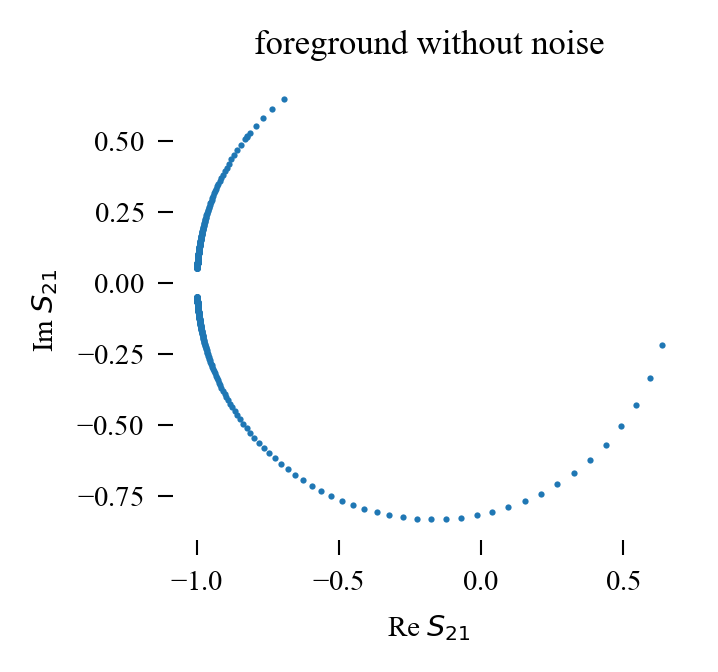

In [3]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(fg.real, fg.imag, '.')
ax.plot([0, -1], [0, 0], marker='x', linestyle='none', color='gray')
ax.set_title('foreground without noise');

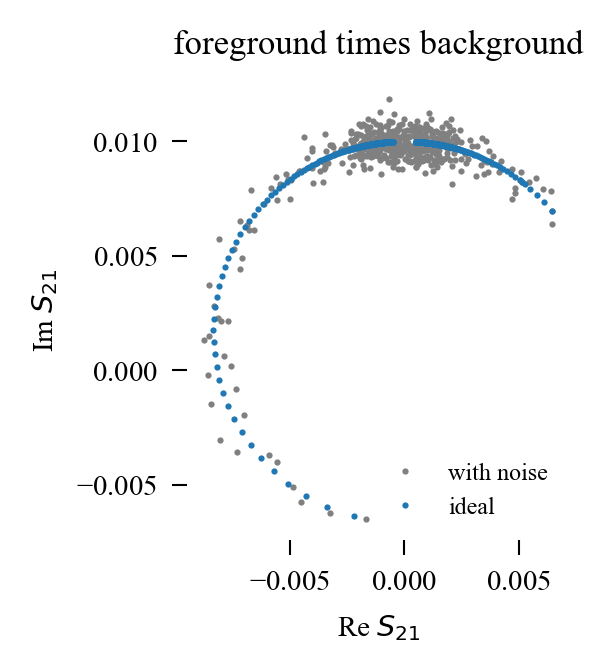

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(s21n.real, s21n.imag, '.', color='gray', label='with noise')
ax.plot(s21.real, s21.imag, '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

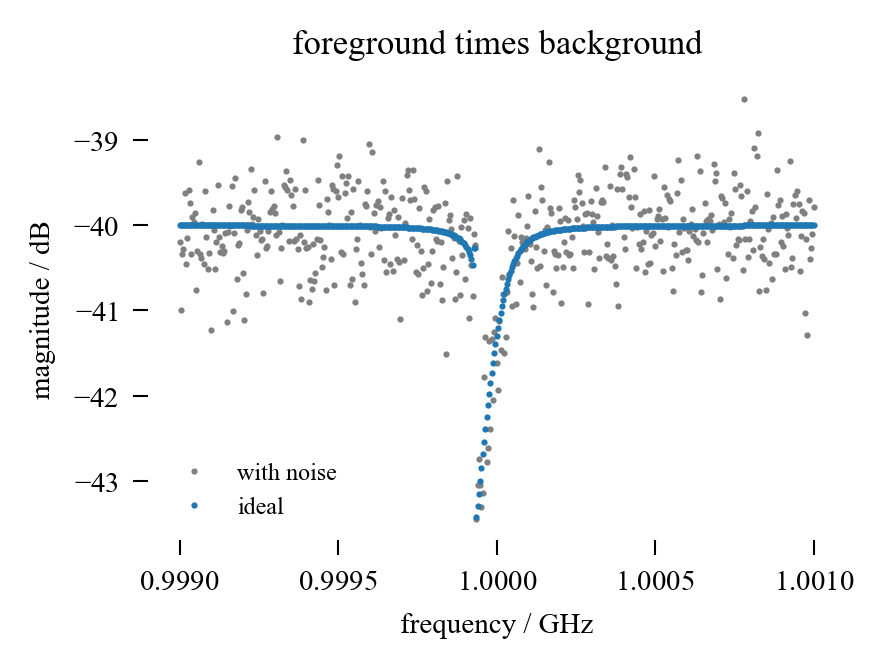

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('magnitude / dB')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21n)), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21)), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

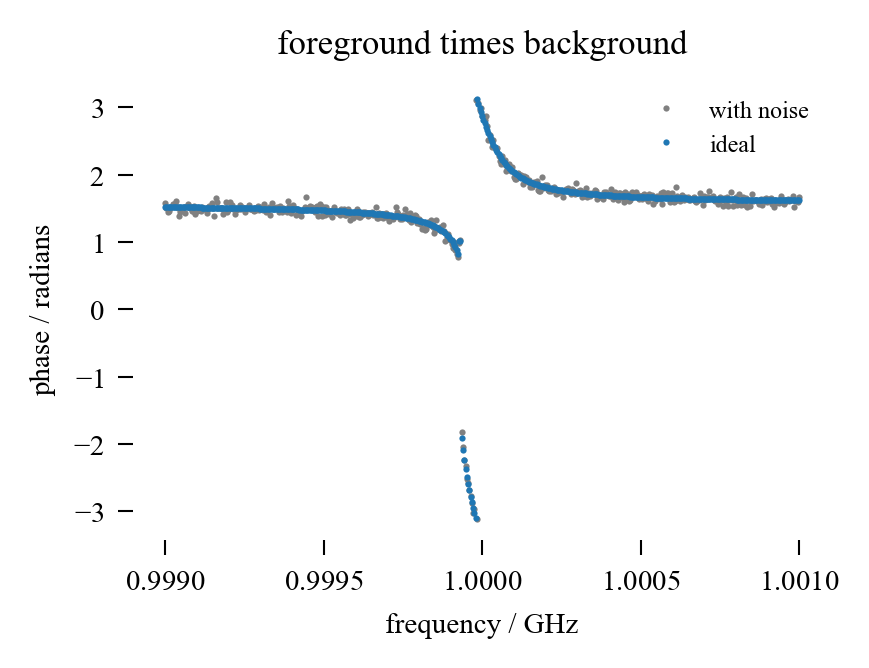

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('phase / radians')
ax.plot(1e-9 * f, np.angle(s21n), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, np.angle(s21), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

## Fit the model to the data using a ReflectionNonlinearFitter.

Here, we know the standard error of each data point because we added the noise. If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [7]:
resonator = reflection.ReflectionNonlinearFitter(frequency=f, data=s21n, errors=(1 + 1j) * noise * np.ones(f.size), choose=choose)
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(complex_constant) * Model(reflection_nonlinear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 1002
    # variables        = 6
    chi-square         = 1025.50276
    reduced chi-square = 1.02962125
    Akaike info crit   = 35.2313605
    Bayesian info crit = 64.6898802
[[Variables]]
    magnitude:              0.00996443 +/- 2.3749e-05 (0.24%) (init = 0.0106585)
    phase:                 -1.57367685 +/- 0.00257930 (0.16%) (init = -1.555847)
    resonance_frequency:    1.0000e+09 +/- 1325.69665 (0.00%) (init = 9.9996e+08)
    coupling_loss:          5.0731e-05 +/- 5.7174e-07 (1.13%) (init = 7.404657e-05)
    internal_loss:          9.8885e-06 +/- 5.7856e-07 (5.85%) (init = 2.195727e-05)
    normalized_input_rate: -1.2194e-09 +/- 4.3215e-11 (3.54%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(resonance_frequency, normalized_input_rate) = -0.730
    C(internal_loss, normalized_inpu

## How well do the fit values match the actual values, given the fit standard errors?

In [8]:
print("Normalized deviations: |fit_value - true_value| / fit_standard_error")
print("Q_i: {:.2f}".format(abs(resonator.Q_i - 1 / internal_loss) / resonator.Q_i_error))
print("Q_c: {:.2f}".format(abs(resonator.Q_c - 1 / coupling_loss) / resonator.Q_c_error))
print("f_r: {:.2f}".format(abs(resonator.f_r - f_r) / resonator.f_r_error))
print("magnitude: {:.2f}".format(abs(resonator.magnitude - magnitude) / resonator.magnitude_error))
print("phase: {:.2f}".format(abs(resonator.phase - phase) / resonator.phase_error))
print("normalized_input_rate: {:.2f}".format(abs(resonator.normalized_input_rate - normalized_input_rate) / resonator.normalized_input_rate_error))

Normalized deviations: |fit_value - true_value| / fit_standard_error
Q_i: 0.19
Q_c: 1.30
f_r: 0.94
magnitude: 1.50
phase: 1.12
normalized_input_rate: 0.64


## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance.

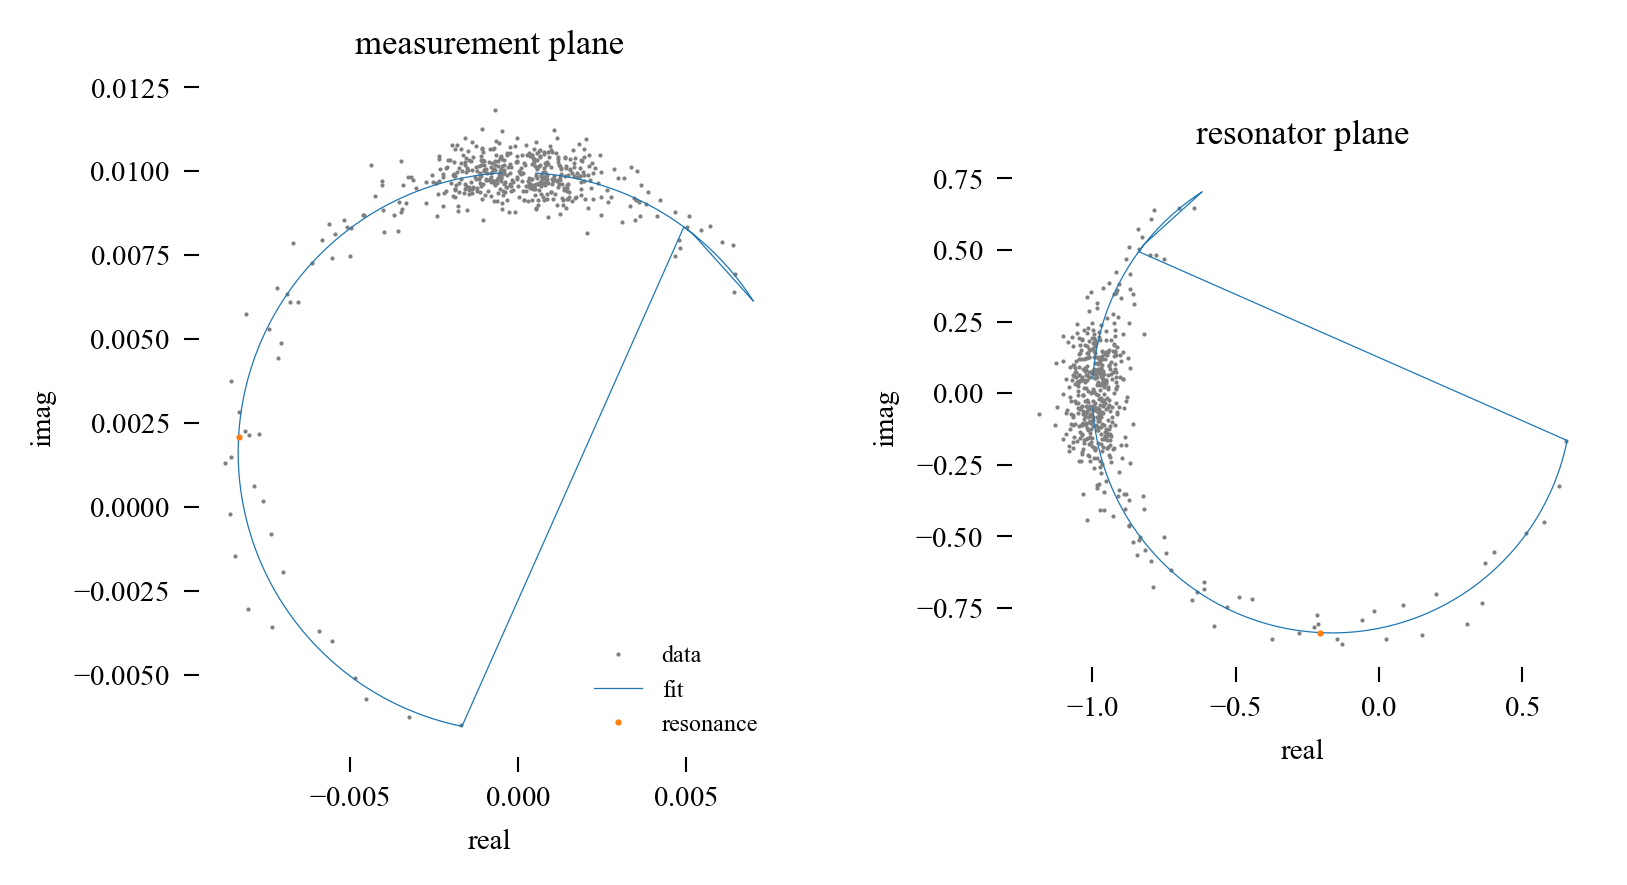

In [9]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

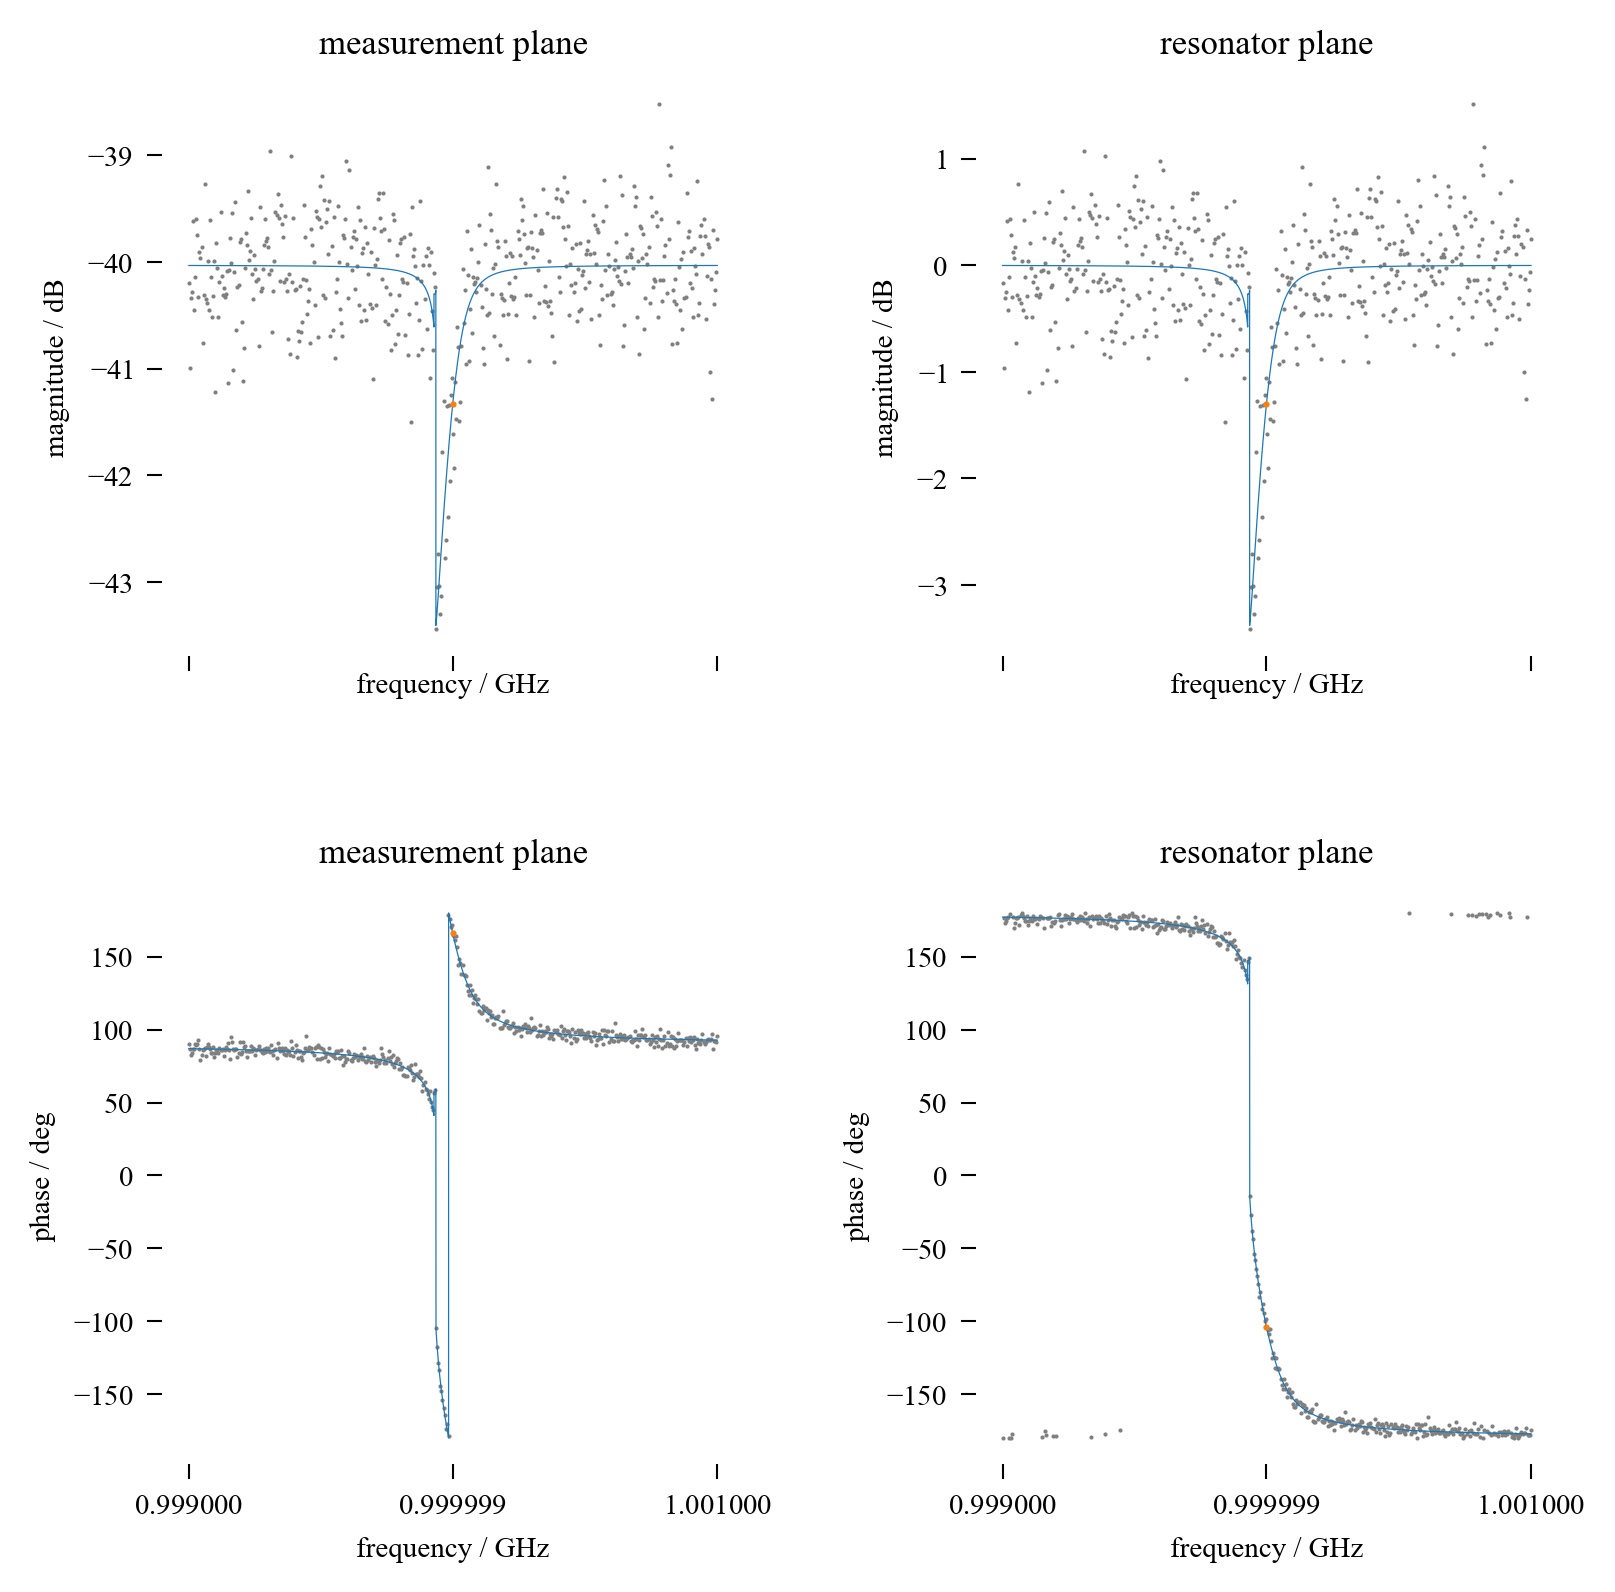

In [10]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);